# TEM Wrapper Tutorial

In this tutorial, we will simulate a cryo-em experiement of the structure of the human 80S ribosome, protein with PDB code 4V6X [1] using our library. In order to run the tests, it is also necessary to have installed the TEM-simulator [2].


<p align="center">
    <img src="4v6x_atomic_model.png" width=350 height=350 />
    <p style="text-align: center">
        Figure 1: Atomic model of the human 80S ribosome
    </p>
</p>

[1] https://www.rcsb.org/structure/4v6x
[2] http://tem-simulator.sourceforge.net/

### TEM-simulator

The TEM-simulator is a software developed to simulate a cryo-em experiment. It works by basically passing a file path as parameter. The file which is referenced contains information about the experiment, such the files that will be used and experiments configurations and required outputs.

### TEMSimulator class

There are two configurations files that needed to be provided when creating a TEMSimulator object, they are:

* `path_config` path of the file that contains the following:
    - pdb_file: the path for the .pdb file
    - mrc_keyword: the name of the .mrc files that will be generated
    - output_dir: where all the genereted files will be outputted
    - local_sim_dir: the path on your computer where the TEM-simulator is located<br><br>

* `sim_config` path of the file that contains details of the simulation, such as beam and optics parameters.


The TEMSimulator class uses extensivily functions from `ioSPI`, which provides helper functions for tem.py processing of I/O operations. The main goal of this helper is to fill the `input.inp` file which will be used by the TEM-simulator.

It is also possible to define the parameters for the simulation in a python `dict`, and use the `write_inp_file` function on the `cryoemio` module from `ioSPI`

In [1]:
from matplotlib import pyplot as plt, axes as ax
import torch
import numpy as np
import os

from ioSPI import cryoemio, fourier
from simSPI import tem
from simSPI import transfer
from simSPI.linear_simulator import noise_utils
from simSPI.linear_simulator import shift_utils


#Helper functions
def plot_image(img, scale, cmap='gray'):
    height, width = img.shape
    px = 1/plt.rcParams['figure.dpi']
    plt.figure(figsize=(height*px*scale, width*px*scale))
    plt.imshow(img, cmap)
    plt.axis('off')
    plt.show()

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [2]:
sim_config = os.path.join('notebooks', 'sim_config.yaml')
path_config = os.path.join('notebooks', 'path_config.yaml')

In [4]:
temSimulator = tem.TEMSimulator(path_config, sim_config)

Each particle has a orientation due to particle rotations. We can manually give the rotations that lead to the images of different particles as a parameter in the TEM-simulator. We use the function `create_crd_file` with this purpose.

In [4]:
#After running this function, I opened the generated file and edited to the simulation
#behave as expected.
#temSimulator.create_crd_file(5)

C:\Users\Luis\Anaconda3\envs\simSPI\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [26]:
temSimulator.write_inp_file()

In [5]:
temSimulator.run()

After running the TEM-simulator you should get a .mrc file as this one.

C:\Users\Luis\Anaconda3\envs\simSPI\lib\site-packages\mrcfile\mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x44 0x11 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


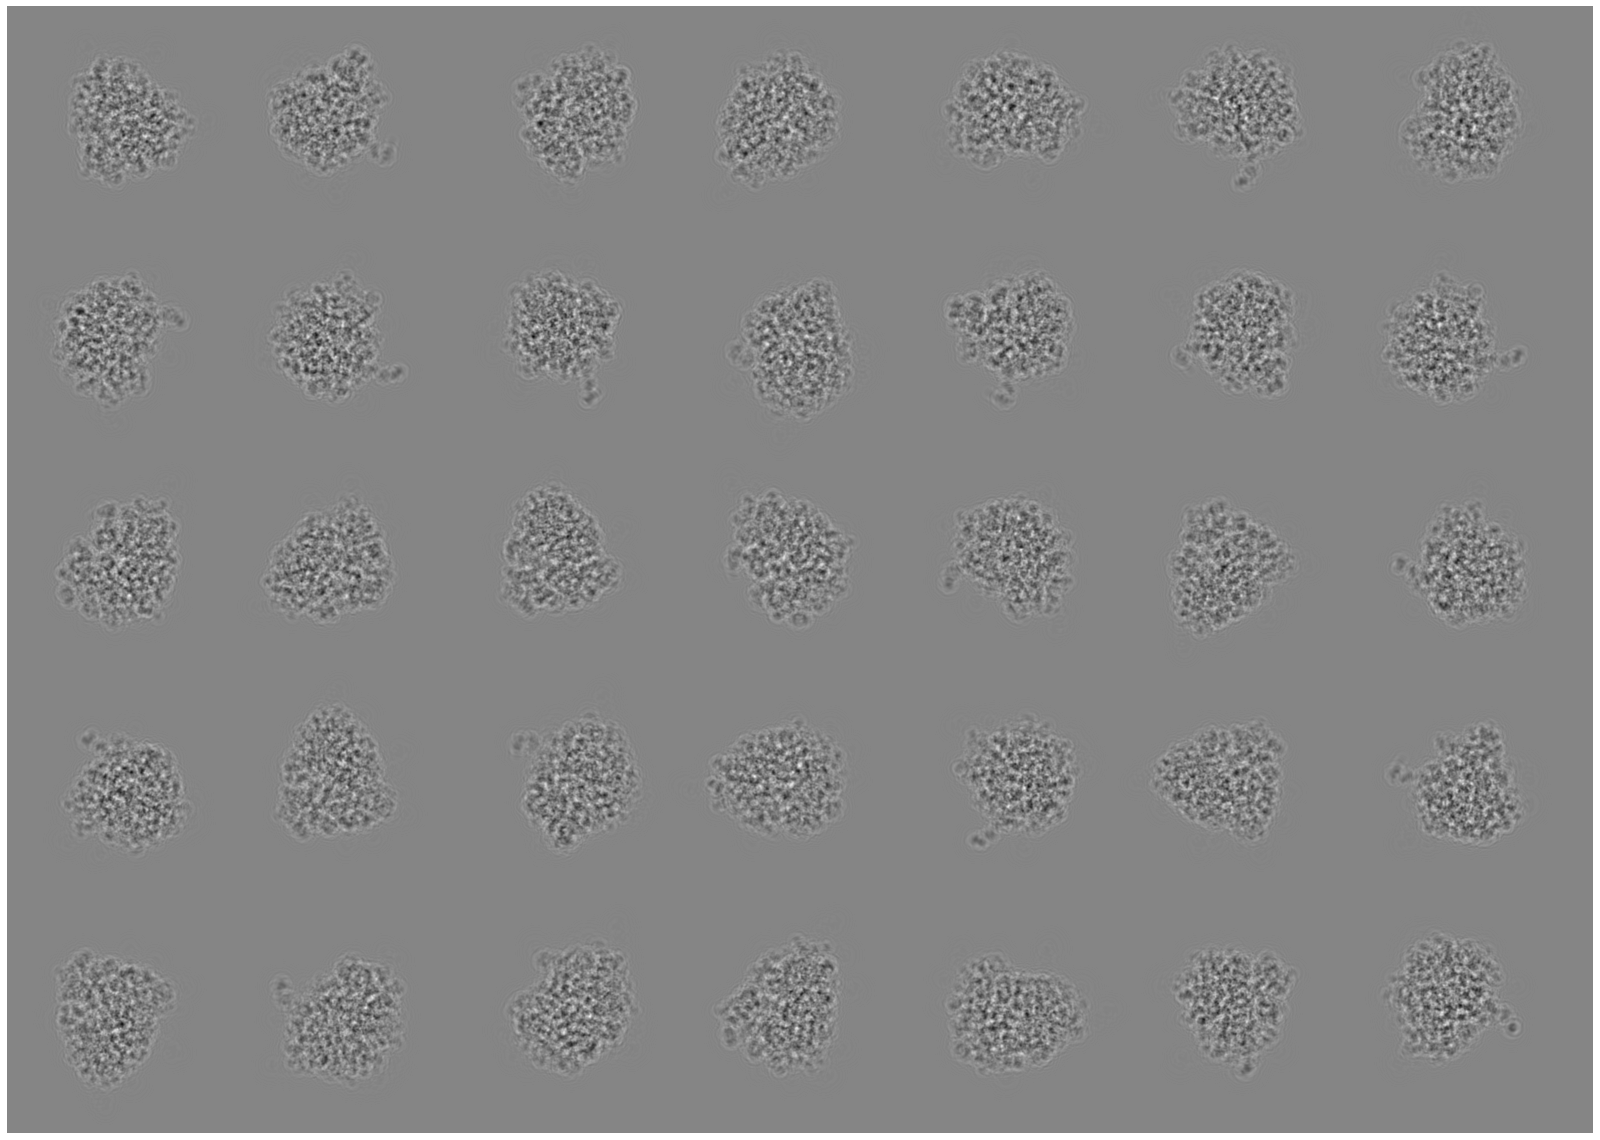

In [57]:
data = cryoemio.mrc2data(temSimulator.output_path_dict["mrc_file"])
micrograph = data[0, ...]

plot_image(micrograph, scale=0.5)

### Linear simulator
We provide several functionalities to work with micrographs. For instance, you can use the `linear_simulator.noise_utils` to apply gaussian noise to the micrograph. In order to to so we have to instanciate a `Noise` object, which uses PyTorch as backend. This object only receives as input a config `dict`. After instanciated we can use the `Noise.forward` function to apply the noise to the micrograph.

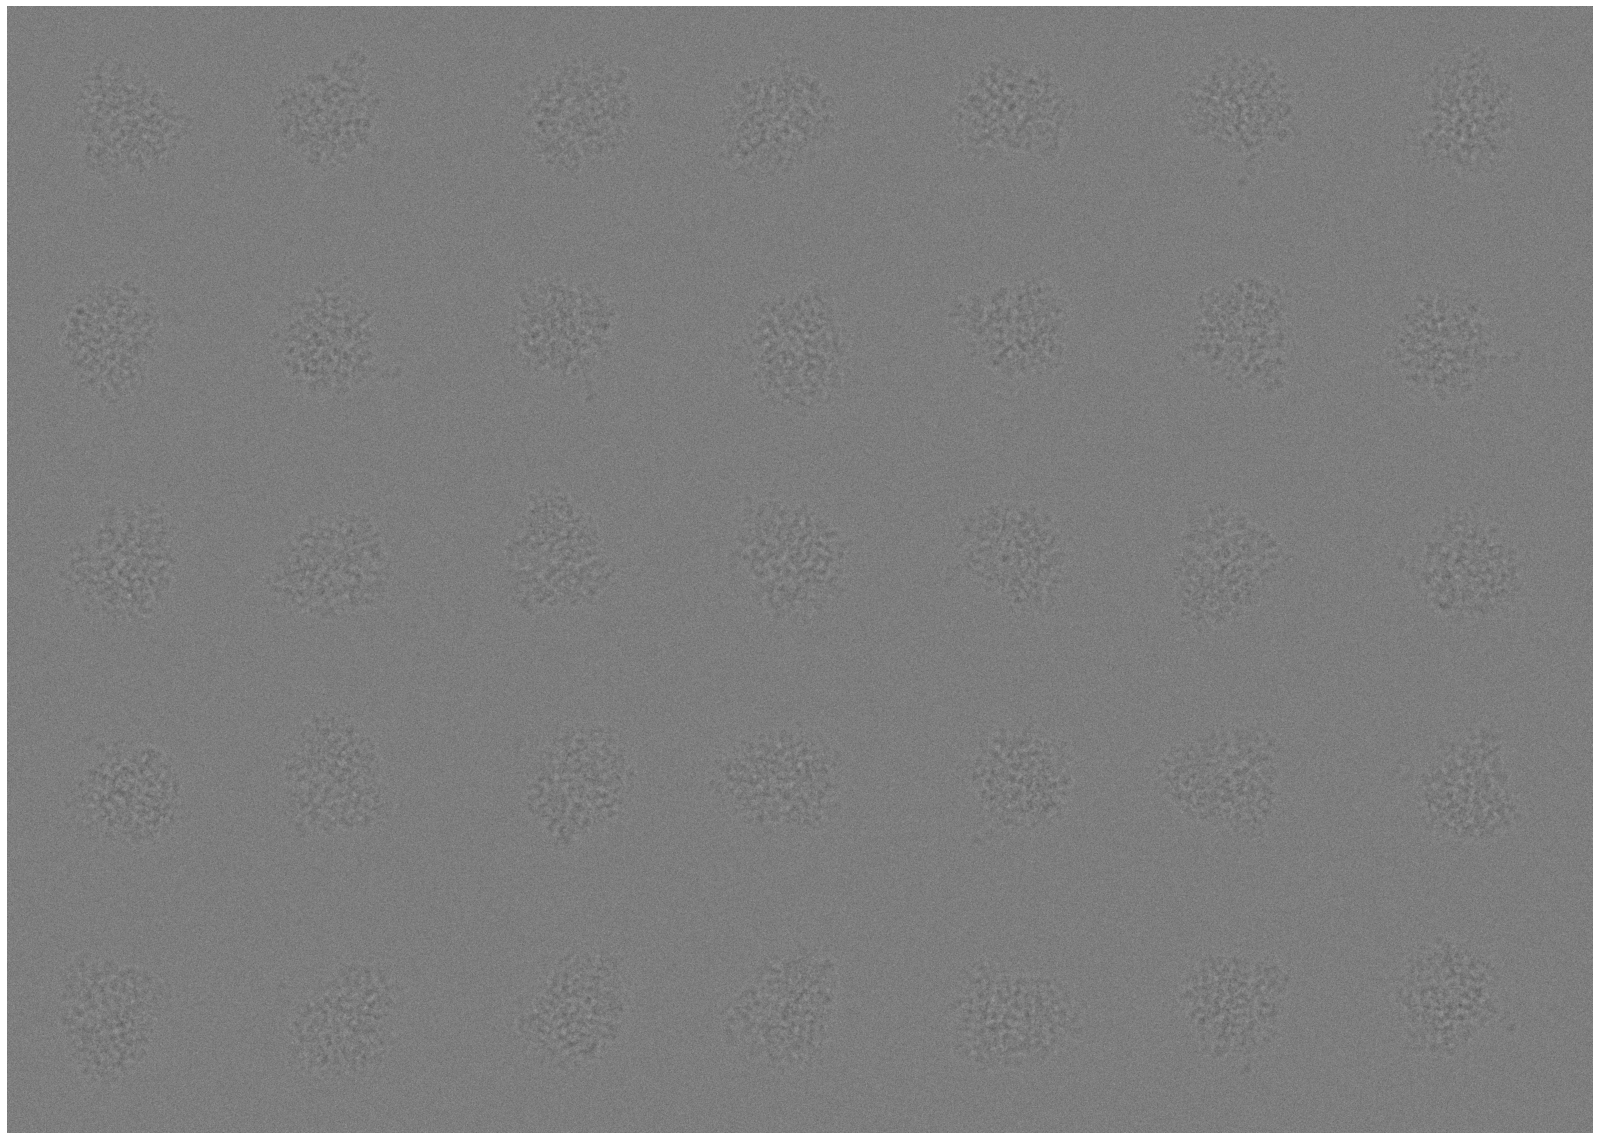

In [56]:
#Define the Noise that will be used
noise_config = {'noise': True, 'noise_sigma': 0.08, 'noise_distribution': 'gaussian'}
noise_config = AttrDict(noise_config)

#Create Noise object
gaussain_noise = noise_utils.Noise(noise_config)

#Apply the gaussian noise to the micrograph
micrograph_with_noise = gaussain_noise.forward(torch.tensor(micrograph))
micrograph_with_noise = micrograph_with_noise.numpy()

#Plot micrograph with gaussian noise added
plot_image(micrograph_with_noise, scale=0.5)

Since the `create_crd_file` function creates the coordinates for the particles in random rotations, but, with positions in a grid like manner, it is very easy to recover the images of each of the particles used in the simulation with the `extract_particles` function.

In [9]:
#Selecting only the three first particles out of the 35
particles = temSimulator.extract_particles(micrograph, 5)[0:3]

C:\Users\Luis\Anaconda3\envs\simSPI\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


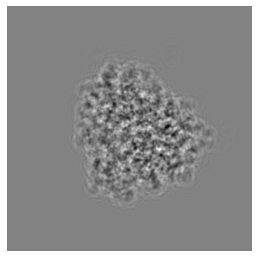

In [69]:
plot_image(particles[0], scale=0.4)

We additionaly have the `shift_utils` module from `linear_simulator`. Having extracted the particles from the micrograph we can use the `Shift` class to apply a spatial shift in the image particles.

In [12]:
#Defining shift config and params
n_particles = particles.shape[0]
box_size = particles.shape[1]
shift_config = {'side_len': box_size, 'batch_size': n_particles, 'pixel_size': 1}
shift_config = AttrDict(shift_config)
shift_params = {'shift_x': torch.FloatTensor(n_particles).uniform_(-200,200),
                'shift_y': torch.FloatTensor(n_particles).uniform_(-200,200)}

#Instanciate a shift object
shift = shift_utils.Shift(shift_config)

In [13]:
shift_params

{'shift_x': tensor([179.8459,  42.8899, -16.6172]),
 'shift_y': tensor([-169.9610, -125.6542,   12.3092])}

Since the shift is done in fourier space, we have to calculate the fourier transform of the image particles.

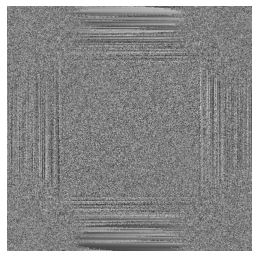

In [15]:
#Calculate the fourier transform of the particles
particles_ft = fourier.fft2d(arr2d=particles, mode='forward', batch=True)

#Calculate the phases and plot the phase spectrum for the first particle
particles_ft_phase = np.angle(particles_ft)
plot_image(particles_ft_phase[0], scale=0.4)

After computing the fourier transform of the particles we apply the phase shifts.

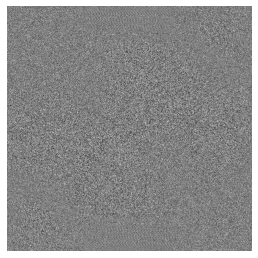

In [65]:
#Apply phase-shift in fourier domain
particles_ft = torch.tensor(particles_ft).reshape(n_particles, 1, box_size, box_size)
particles_ft_modulated = shift.forward(particles_ft, shift_params)

#Reshape the output and convert it back to a numpy array
particles_ft_modulated = particles_ft_modulated.reshape(n_particles, box_size, box_size).numpy()

#Calculate and plot the phase spectrum
particles_ft_mod_phase = np.angle(particles_ft_modulated)
plot_image(particles_ft_mod_phase[0], scale=0.4)

In [20]:
particles_ft = particles_ft.reshape(n_particles, box_size, box_size).numpy()

#Recover and plot the image in spatial domain
particles_ift = fourier.fft2d(particles_ft, 'inverse', batch=True)
plot_image(np.abs(particles_ift[0]), scale = 0.4)

(-0.5, 808.5, 808.5, -0.5)

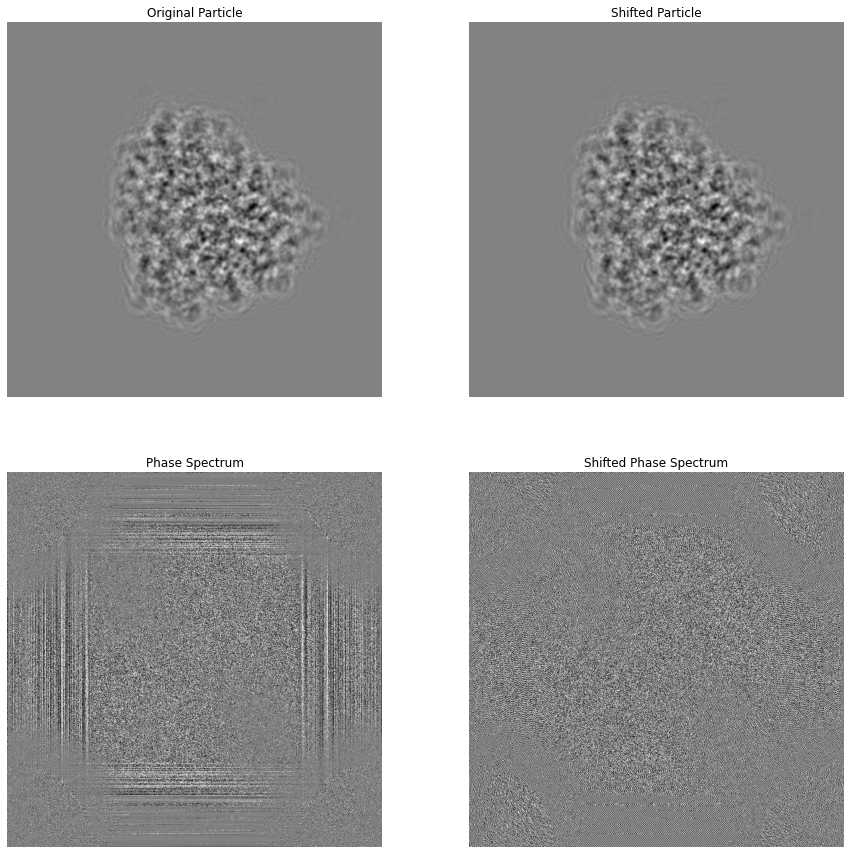

In [22]:
px = 1/plt.rcParams['figure.dpi']
scale = 1.35

f, ax = plt.subplots(2,2, figsize=(box_size*px*scale,box_size*px*scale))

ax[0,0].imshow(particles[0], cmap='gray')
ax[0,0].set_title('Original Particle')
ax[0,0].axis('off')

ax[0,1].imshow(np.abs(particles_ift[0]), cmap='gray')
ax[0,1].set_title('Shifted Particle')
ax[0,1].axis('off')

ax[1,0].imshow(np.abs(particles_ft_phase[0]), cmap='gray')
ax[1,0].set_title('Phase Spectrum')
ax[1,0].axis('off')

ax[1,1].imshow(np.abs(particles_ft_mod_phase[0]), cmap='gray')
ax[1,1].set_title('Shifted Phase Spectrum')
ax[1,1].axis('off')

# Transfer

The transfer module provides important resources for working with the Contrast Transfer Function (CTF). Includying the generation of user defined or random CTFs that can be used to create image particles closer to the ones who would be obtained in a real cryo-em experiment.

In [23]:
#Define parameters and create the ctf
n_pixels = particles[0].shape[0]
p_size = 1
freq_mag_2d, angles_rad = transfer.ctf_freqs(n_pixels, p_size)
ctf = transfer.eval_ctf(s=freq_mag_2d, a=angles_rad, def1=1e4, def2=1.1e4)

### Image formation

Now we can simulate the image formation in cryo-em process by multiplying in fourier space the particle fourier transform with the CTF. More formaly, we have $$\mathcal{F}(\text{Particle}) \times CTF = \mathcal{F}(\text{Particle} * PSF),$$ where $\text{PSF} = \mathcal{F}(\text{CTF})^{-1}$. As we did before, we will use the `fourier` module from `ioSPI` to calculate the fourier transform and the inverse fourier transform.

(-0.5, 808.5, 808.5, -0.5)

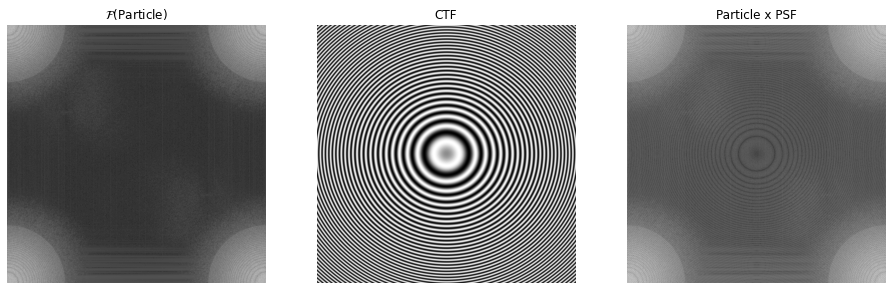

In [64]:
#Calculate the product of the ctf with the fourier transform of the particle
particle_ft_ctf = ctf * fourier.fft2d(arr2d = particles[0], mode = 'forward')

px = 1/plt.rcParams['figure.dpi']
scale = 1.4

f, ax = plt.subplots(1,3, figsize=(box_size*px*scale,box_size*px*scale))


ax[0].imshow(np.log(np.abs(particles_ft[0])), cmap='gray')
ax[0].set_title('$\mathcal{F} ($Particle$)$')
ax[0].axis('off')

ax[1].imshow(ctf, cmap='gray')
ax[1].set_title('CTF')
ax[1].axis('off')

ax[2].imshow(np.log(np.abs(particle_ft_ctf)), cmap='gray')
ax[2].set_title('Particle x PSF')
ax[2].axis('off')

Finally, we can simulate the effect of the CTF in the final image by calculating: $$\text{Particle} * \text{PSF} = \mathcal{F}^{-1}(\mathcal{F}(Particle) \times CTF)$$

(-0.5, 808.5, 808.5, -0.5)

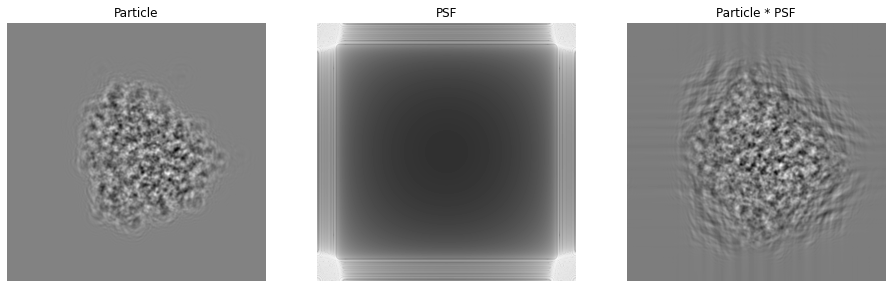

In [63]:
#Calculate the PSF, which is simply the inverse fourier transform of the ctf
psf = fourier.fft2d(arr2d = ctf, mode = 'inverse')

#Calculate the particle convolved with PSF
particle_conv_psf = fourier.fft2d(arr2d = particle_ft_ctf, mode = 'inverse')

px = 1/plt.rcParams['figure.dpi']
scale = 1.4
f, ax = plt.subplots(1,3, figsize=(box_size*px*scale,box_size*px*scale))


ax[0].imshow(particles[0], cmap='gray')
ax[0].set_title('Particle')
ax[0].axis('off')

ax[1].imshow(np.log(np.abs(psf)), cmap='gray')
ax[1].set_title('PSF')
ax[1].axis('off')

ax[2].imshow(np.abs(particle_conv_psf), cmap='gray')
ax[2].set_title('Particle * PSF')
ax[2].axis('off')
